In [1]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [2]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [3]:
img_dirs

['./dataset/amrabat',
 './dataset/bono',
 './dataset/hakimi',
 './dataset/ounahi',
 './dataset/ziach']

In [4]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
face_cascade = cv2.CascadeClassifier('./opencv/data/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/data/haarcascades/haarcascade_eye.xml')

def get_cropped_image_if_2_eyes(image_path):
    if not image_path:
        return None
    
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
    
    return None



In [6]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1   
        else:
            continue 

amrabat
Generating cropped images in folder:  ./dataset/cropped/amrabat
bono
Generating cropped images in folder:  ./dataset/cropped/bono
hakimi
Generating cropped images in folder:  ./dataset/cropped/hakimi
ounahi
Generating cropped images in folder:  ./dataset/cropped/ounahi
ziach
Generating cropped images in folder:  ./dataset/cropped/ziach


In [7]:
celebrity_file_names_dict 

{'amrabat': ['./dataset/cropped/amrabat/amrabat1.png',
  './dataset/cropped/amrabat/amrabat2.png',
  './dataset/cropped/amrabat/amrabat3.png',
  './dataset/cropped/amrabat/amrabat4.png',
  './dataset/cropped/amrabat/amrabat5.png',
  './dataset/cropped/amrabat/amrabat6.png',
  './dataset/cropped/amrabat/amrabat7.png',
  './dataset/cropped/amrabat/amrabat8.png',
  './dataset/cropped/amrabat/amrabat9.png',
  './dataset/cropped/amrabat/amrabat10.png',
  './dataset/cropped/amrabat/amrabat11.png',
  './dataset/cropped/amrabat/amrabat12.png',
  './dataset/cropped/amrabat/amrabat13.png',
  './dataset/cropped/amrabat/amrabat14.png',
  './dataset/cropped/amrabat/amrabat15.png',
  './dataset/cropped/amrabat/amrabat16.png',
  './dataset/cropped/amrabat/amrabat17.png',
  './dataset/cropped/amrabat/amrabat18.png',
  './dataset/cropped/amrabat/amrabat19.png',
  './dataset/cropped/amrabat/amrabat20.png',
  './dataset/cropped/amrabat/amrabat21.png',
  './dataset/cropped/amrabat/amrabat22.png',
  './dat

In [8]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'amrabat': 0, 'bono': 1, 'hakimi': 2, 'ounahi': 3, 'ziach': 4}

In [9]:

import pywt   

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [10]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])   

In [11]:
len(X[0])

4096

In [12]:
y[0]

0

In [13]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(486, 4096)

Model Training Step

Svm/Rbf kernel/Heuristic finetuning

In [14]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9016393442622951

In [19]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        20
           1       0.86      1.00      0.93        19
           2       1.00      0.89      0.94        18
           3       1.00      0.56      0.71        18
           4       0.88      0.96      0.92        47

    accuracy                           0.90       122
   macro avg       0.92      0.88      0.89       122
weighted avg       0.91      0.90      0.89       122



In [20]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [21]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [22]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.837938,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.629186,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.829642,{'logisticregression__C': 1}


In [23]:
best_estimators['svm'].score(X_test,y_test)

0.8770491803278688

In [24]:
best_estimators['random_forest'].score(X_test,y_test)

0.6639344262295082

In [25]:
best_estimators['logistic_regression'].score(X_test,y_test)


0.8360655737704918

In [26]:
best_clf = best_estimators['svm']

Text(95.72222222222221, 0.5, 'Truth')

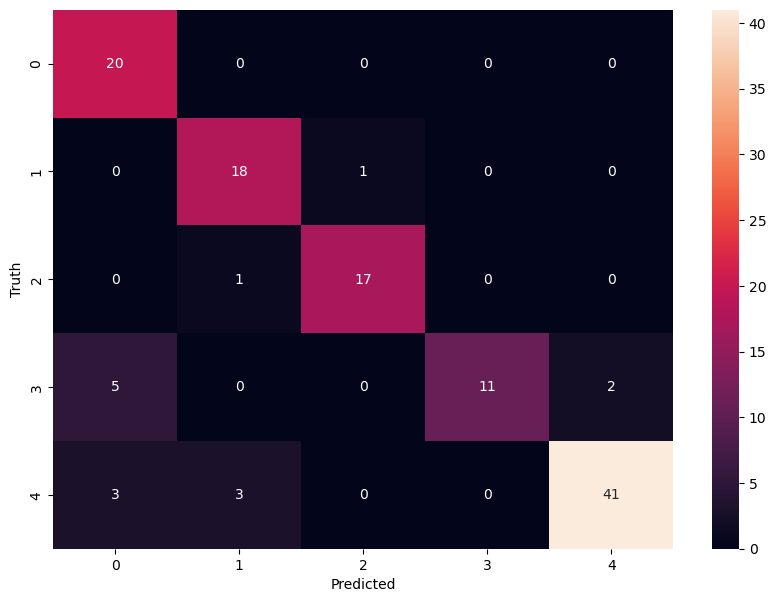

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(y_test, best_clf.predict(X_test))
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Save the model

In [68]:

import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [69]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

Test the model

In [115]:
img_test = cv2.imread('./test_images/five-moroccan-players-among-100-best-footballers-worldwide-in-2022-800x450.jpeg')
img_test.shape

(450, 800, 3)

In [117]:
gray = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
gray.shape

(450, 800)

In [119]:
faces = face_cascade.detectMultiScale(gray, 1.3, 1)
faces

array([[187, 102,  93,  93],
       [330, 102,  87,  87],
       [410,  74,  41,  41],
       [ 14, 129,  94,  94],
       [664, 124,  89,  89],
       [ 92, 298,  28,  28]])

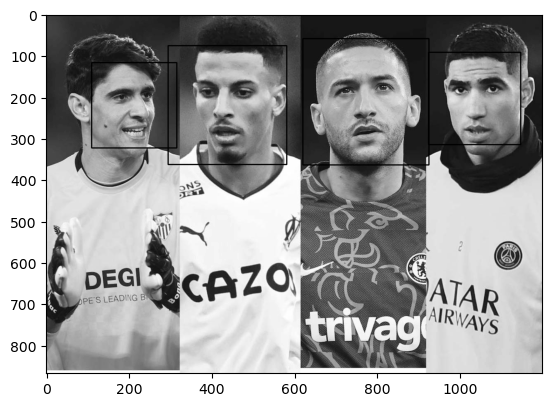

In [133]:
img1 =  cv2.imread('./test_images/MAROC_TOP_10.jpg')
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 2)
for (x, y, w, h) in faces:
    cv2.rectangle(gray, (x, y), (x + w, y + h), (0, 255, 0), 2)


plt.imshow(gray, cmap='gray' )


In [28]:
import joblib
import json
import numpy as np
import base64
import cv2

In [29]:
__class_name_to_number = {}
__class_number_to_name = {}

__model = None